In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from IPython.display import display, Markdown, Math

seed = 42

_Частина 3_

Завдання: розробити програмне забезпечення для реалізації двошарового персептрону із структурою 2-3-1.

Передбачити режим навчання «ON-LINE» та режим розпізнавання.

Піддослідна функція $х_1+х_2=у$

In [223]:
class NeuralNetwork:
    """
    N-layer neural network mathematic model with sigmoid activation function
    """

    def __init__(self, npl, add_bias=True):
        """
        Init starting values, first step
        
        Args:
            npl: Neuron-per-Layer (i.e. 2-3-1 == [2, 3, 1])
            add_bias: To add additional weight to itself on every neuron
        """
        self._npl = npl
        self.add_bias = add_bias
        # First_neuron_number . depends on bias
        self.one_or_zero = 1 if add_bias else 0
        # Add bias neuron if it needed
        self._inputs = []
        self._result = []
        
        self.weights = []
        for i in range(len(npl)-1):
            w = np.random.default_rng(seed).uniform(
                low=-1.0,
                high=1.0,
                size=(npl[i]+self.one_or_zero)*npl[i+1],
            ).round(3).reshape((npl[i]+self.one_or_zero, npl[i+1]))
            self.weights.append(w)
            
        self.neurons = []
        for i in range(len(npl)):
            self.neurons.append(
                np.concatenate(([1], np.empty(npl[i])))
                if self.add_bias else
                np.empty(npl[i])
            )
        self.epoch_history = []  # same as y_i
        self.error_history = []  # same as dn_i
        

    def sigm(self, x):
        """
        Sigmoidal activation function
        """
        return 1 / (1 + np.exp(-x))

    def sigm_der(self, w):
        """
        Args:
            w: the previous output value of the neuron
        """
        return w * (1 - w)

    def _step_forward(self):
        """
        Make one calculation forward through all NN
        """
        for i in range(1, len(self._npl)):
            self.neurons[i][self.one_or_zero:] = self.sigm(self.neurons[i-1] @ self.weights[i-1])
            
        self.epoch_history.append(self.neurons[-1][self.one_or_zero:])
        self.error_history.append(
            np.abs((self._result - self.epoch_history[-1]) / self._result)
        )

    def _back_propagate(self, learning_rate):
        """
        Correct previous iteration
        """
        l = learning_rate
        last_delta_w = (self.neurons[-1][self.one_or_zero:] - self._result) * self.sigm_der(self.neurons[-1][self.one_or_zero:])
        
        for i in range(len(self._npl) - 2, -1, -1):
            correction = np.transpose([self.neurons[i]]) @ ([last_delta_w]) * l
            self.weights[i] -= correction
            last_delta_w = (
                (last_delta_w @ self.weights[i].T)
                * self.sigm_der(self.neurons[i])
            )[self.one_or_zero:]

    def train(self, inputs, outputs, acceptable_error=0.01, learning_rate=0.1, max_epoch_iteration=5000):
        """
        Train function
        Make forward step and correct weights.
        Loop that untill error will be small enough.
        Limit maximum number of epochs.
        """
        i = 1
        inp_outps = list(zip(inputs, outputs))
        enought = False
        while (i < max_epoch_iteration) and (not enought):
            for inp, outp in inp_outps:
                self.neurons[0][self.one_or_zero:] = np.array(inp)
                self._result = np.array(outp)
                self._step_forward()
                if self.error_history[-1] <= acceptable_error:
                    enought = True
                    break
                self._back_propagate(learning_rate)
                i += 1
            np.random.shuffle(inp_outps)
        return i
    
    def predict(self, input_vector):
        """
        Predict input vector with current weights
        """
        self.neurons[0][self.one_or_zero:] = np.array(input_vector)
        self._step_forward()
        return self.neurons[-1][self.one_or_zero:]

In [224]:
perceptron = NeuralNetwork([2, 2, 1], add_bias=True)

In [225]:
def gen_train(number):
    for i in range(number):
        x1 = round(np.random.default_rng().uniform(low=-10.0, high=10.0), 3)
        y = round(np.random.default_rng().uniform(low=0, high=1.0), 3)
        x2 = round(y-x1, 3)
        yield [x1, x2], y
    
inputs, outputs = [], []
for i, j in gen_train(100):
    inputs.append(i)
    outputs.append([j])

# print(*list(zip(inputs, outputs)), sep='\n')

In [226]:
iterations_number = perceptron.train(inputs, outputs, learning_rate=0.8, max_epoch_iteration=10000)
print("Iterations number", iterations_number)
print("Final error", perceptron.error_history[-1])

Iterations number 577
Final error [0.00478037]


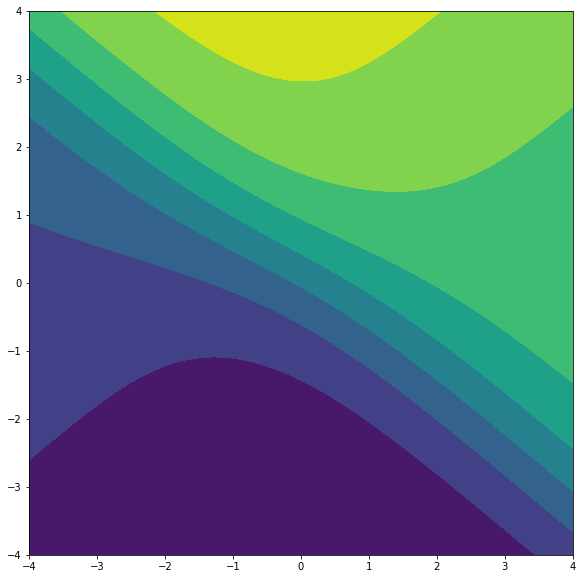

In [230]:
x1 = np.linspace(-4, 4, 100)
x2 = np.linspace(-4, 4, 100)
xx1, xx2 = np.meshgrid(x1, x2, sparse=False)
yy = np.empty(xx1.shape)
for i in range(xx1.shape[0]):
    for j in range(xx1.shape[1]):
        yy[i][j] = perceptron.predict([xx1[i][j], xx2[i][j]])

h = plt.contourf(xx1, xx2, yy,)
plt.axis('scaled')
plt.show()

In [231]:
perceptron.predict([0.5, -0.2])

array([0.45916601])